# Time Series Exercise - 

### Follow along with the instructions in bold. Watch the solutions video if you get stuck!

## The Data

** Source: https://datamarket.com/data/set/22ox/monthly-milk-production-pounds-per-cow-jan-62-dec-75#!ds=22ox&display=line **

**Monthly milk production: pounds per cow. Jan 62 - Dec 75**

** Import numpy pandas and matplotlib **

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

** Use pandas to read the csv of the monthly-milk-production.csv file and set index_col='Month' **

In [2]:
milk = pd.read_csv('./monthly-milk-production.csv',index_col='Month')
milk.size

168

** Check out the head of the dataframe**

In [3]:
milk.head()

,Milk Production
Month,
1962-01-01 01:00:00,589.0
1962-02-01 01:00:00,561.0
1962-03-01 01:00:00,640.0
1962-04-01 01:00:00,656.0
1962-05-01 01:00:00,727.0


** Make the index a time series by using: **

    milk.index = pd.to_datetime(milk.index)

In [4]:
milk.index = pd.to_datetime(milk.index)

** Plot out the time series data. **

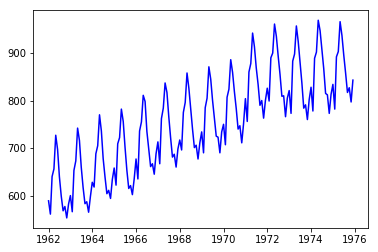

In [5]:
plt.plot(milk.index,milk['Milk Production'],'b-')

___

### Train Test Split

** Let's attempt to predict a year's worth of data. (12 months or 12 steps into the future) **

** Create a test train split using indexing (hint: use .head() or tail() or .iloc[]). We don't want a random train test split, we want to specify that the test set is the last 12 months of data is the test set, with everything before it is the training. **

In [6]:
x_train = milk.iloc[:-12,:]
x_train.size

156

In [7]:
x_test = milk.tail(12)
x_test.size

12

In [8]:
x_test.head()

,Milk Production
Month,
1975-01-01 01:00:00,834.0
1975-02-01 01:00:00,782.0
1975-03-01 01:00:00,892.0
1975-04-01 01:00:00,903.0
1975-05-01 01:00:00,966.0


In [9]:
x_train.head()

,Milk Production
Month,
1962-01-01 01:00:00,589.0
1962-02-01 01:00:00,561.0
1962-03-01 01:00:00,640.0
1962-04-01 01:00:00,656.0
1962-05-01 01:00:00,727.0


### Scale the Data

** Use sklearn.preprocessing to scale the data using the MinMaxScaler. Remember to only fit_transform on the training data, then transform the test data. You shouldn't fit on the test data as well, otherwise you are assuming you would know about future behavior!**

In [10]:
from sklearn.preprocessing import MinMaxScaler

In [11]:
scaler = MinMaxScaler()

In [12]:
scaler.fit(x_train[['Milk Production']])

MinMaxScaler(copy=True, feature_range=(0, 1))

In [13]:
y_train_scaled = scaler.transform(x_train[['Milk Production']])

In [14]:
y_test_scaled = scaler.transform(x_test[['Milk Production']])

## Batch Function

** We'll need a function that can feed batches of the training data. We'll need to do several things that are listed out as steps in the comments of the function. Remember to reference the previous batch method from the lecture for hints. Try to fill out the function template below, this is a pretty hard step, so feel free to reference the solutions! **

In [15]:
def next_batch(training_data,batch_size,steps):
    """
    INPUT: Data, Batch Size, Time Steps per batch
    OUTPUT: A tuple of y time series results. y[:,:-1] and y[:,1:]
    """
    
    # STEP 1: Use np.random.randint to set a random starting point index for the batch.
    # Remember that each batch needs have the same number of steps in it.
    # This means you should limit the starting point to len(data)-steps
    start = np.random.randint(len(training_data)-steps)
    #print(start)
    #print(training_data.size)
    # STEP 2: Now that you have a starting index you'll need to index the data from
    # the random start to random start + steps + 1. Then reshape this data to be (1,steps+1)
    y = training_data[start:start +steps + 1].reshape(1,steps+1)
    #print(y.size)
    # STEP 3: Return the batches. You'll have two batches to return y[:,:-1] and y[:,1:]
    # You'll need to reshape these into tensors for the RNN to .reshape(-1,steps,1)
    return y[:,:-1].reshape(-1,steps,1), y[:,1:].reshape(-1,steps,1)

## Setting Up The RNN Model

** Import TensorFlow **

### The Constants

** Define the constants in a single cell. You'll need the following (in parenthesis are the values I used in my solution, but you can play with some of these): **
* Number of Inputs (1)
* Number of Time Steps (12)
* Number of Neurons per Layer (100)
* Number of Outputs (1)
* Learning Rate (0.03)
* Number of Iterations for Training (4000)
* Batch Size (1)

In [16]:
inputs = 1
time_steps = 12
neurons_per_layer = 100
outputs = 1
learning_rate = 0.001
iterations = 6000
batch_size = 1

** Create Placeholders for X and y. (You can change the variable names if you want). The shape for these placeholders should be [None,num_time_steps-1,num_inputs] and [None, num_time_steps-1, num_outputs] The reason we use num_time_steps-1 is because each of these will be one step shorter than the original time steps size, because we are training the RNN network to predict one point into the future based on the input sequence.**  

In [17]:
X = tf.placeholder(dtype=tf.float32,shape=[None,time_steps-1,inputs])
y = tf.placeholder(dtype=tf.float32,shape=[None, time_steps-1,outputs])

** Now create the RNN Layer, you have complete freedom over this, use tf.contrib.rnn and choose anything you want, OutputProjectionWrappers, BasicRNNCells, BasicLSTMCells, MultiRNNCell, GRUCell etc... Keep in mind not every combination will work well! (If in doubt, the solutions used an Outputprojection Wrapper around a basic LSTM cell with relu activation.**

In [18]:
cell =tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.GRUCell(num_units=neurons_per_layer,
                                activation=tf.nn.relu),
    output_size = outputs)

** Now pass in the cells variable into tf.nn.dynamic_rnn, along with your first placeholder (X)**

In [19]:
outputs , states = tf.nn.dynamic_rnn(cell,X,dtype=tf.float32)

### Loss Function and Optimizer

** Create a Mean Squared Error Loss Function and use it to minimize an AdamOptimizer, remember to pass in your learning rate. **

In [20]:
loss = tf.reduce_mean(tf.square(outputs- y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train = optimizer.minimize(loss)

** Initialize the global variables **

In [21]:
init = tf.global_variables_initializer()

** Create an instance of tf.train.Saver() **

In [22]:
saver  = tf.train.Saver()

### Session

** Run a tf.Session that trains on the batches created by your next_batch function. Also add an a loss evaluation for every 100 training iterations. Remember to save your model after you are done training. **

In [23]:
with tf.Session() as sess:
    # CODE HERE!
    sess.run(init)
    for iteration in range (iterations):
        X_batch,y_batch = next_batch(training_data=y_train_scaled,batch_size=batch_size,steps=time_steps-1)
        sess.run(train,feed_dict={X:X_batch,y:y_batch})
        if(iteration%100 == 0):
            error = loss.eval(feed_dict={X:X_batch,y:y_batch})
            print(iteration,"\tError:",error)

    # Save Model for Later
    saver.save(sess, "./ex_time_series_model")

0 	Error: 0.5108443
100 	Error: 0.019928187
200 	Error: 0.04121133
300 	Error: 0.03254741
400 	Error: 0.013368028
500 	Error: 0.00998699
600 	Error: 0.025526164
700 	Error: 0.012723256
800 	Error: 0.012647683
900 	Error: 0.010940358
1000 	Error: 0.016308188
1100 	Error: 0.0085834125
1200 	Error: 0.009324437
1300 	Error: 0.011830785
1400 	Error: 0.006488854
1500 	Error: 0.0075432183
1600 	Error: 0.007325292
1700 	Error: 0.010345363
1800 	Error: 0.007269433
1900 	Error: 0.010189902
2000 	Error: 0.004591476
2100 	Error: 0.008685687
2200 	Error: 0.0058832155
2300 	Error: 0.0064375517
2400 	Error: 0.0051813032
2500 	Error: 0.0061539873
2600 	Error: 0.003064102
2700 	Error: 0.007600632
2800 	Error: 0.008097622
2900 	Error: 0.0039489963
3000 	Error: 0.0029049157
3100 	Error: 0.011094768
3200 	Error: 0.0067215194
3300 	Error: 0.011575941
3400 	Error: 0.005774669
3500 	Error: 0.006520179
3600 	Error: 0.0053094756
3700 	Error: 0.004758564
3800 	Error: 0.006141156
3900 	Error: 0.004402501
4000 	E

______

## Predicting Future (Test Data)

** Show the test_set (the last 12 months of your original complete data set) **

In [24]:
# CODE HERE
with tf.Session() as sess:
    saver.restore(sess,'ex_time_series_model')
    y_pred = sess.run(outputs,feed_dict={X:y_test_scaled[:-1].reshape(-1,time_steps-1,1)})

INFO:tensorflow:Restoring parameters from ex_time_series_model


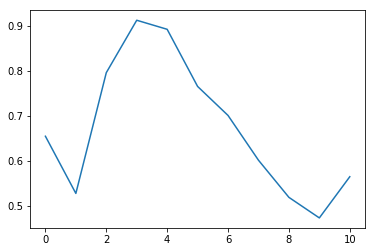

In [25]:
plt.plot( y_pred[0,:,0])

** Now we want to attempt to predict these 12 months of data, using only the training data we had. To do this we will feed in a seed training_instance of the last 12 months of the training_set of data to predict 12 months into the future. Then we will be able to compare our generated 12 months to our actual true historical values from the test set! **

# Generative Session
### NOTE: Recall that our model is really only trained to predict 1 time step ahead, asking it to generate 12 steps is a big ask, and technically not what it was trained to do! Think of this more as generating new values based off some previous pattern, rather than trying to directly predict the future. You would need to go back to the original model and train the model to predict 12 time steps ahead to really get a higher accuracy on the test data. (Which has its limits due to the smaller size of our data set)
** Fill out the session code below to generate 12 months of data based off the last 12 months of data from the training set. The hardest part about this is adjusting the arrays with their shapes and sizes. Reference the lecture for hints.**

In [26]:
with tf.Session() as sess:
    
    # Use your Saver instance to restore your saved rnn time series model
    saver.restore(sess, "./ex_time_series_model")
    trainig_instance= list(y_test_scaled)
    # CODE HERE!
    for iteration in range(len(trainig_instance)- time_steps):
        X_batch = np.array(trainig_instance[-time_steps:]).reshape(1,time_steps,1)
        y_pred = sess.run(outputs,feed_dict={X:X_batch})
        training_instance.append(y_pred[0,-1,0])

INFO:tensorflow:Restoring parameters from ./ex_time_series_model


** Show the result of the predictions. **

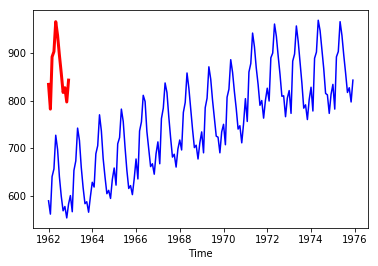

In [27]:
plt.plot(milk.index,milk[['Milk Production']],"b-")
#print(milk[['Month']][:time_steps].shape)
#print(np.reshape(trainig_instance,(12,1)).shape)
#print(milk[['Month']][:time_steps].values)
#print(trainig_instance)
#print(np.reshape(trainig_instance,(12,1)))
#plt.plot(milk[['Month']][:time_steps],np.reshape(trainig_instance,(12,1)).shape,'r-',line_width=3)
plt.plot(milk.index[:time_steps].values,scaler.inverse_transform(np.reshape(trainig_instance,(12,1))),'r-',linewidth=3)

plt.xlabel("Time")

** Grab the portion of the results that are the generated values and apply inverse_transform on them to turn them back into milk production value units (lbs per cow). Also reshape the results to be (12,1) so we can easily add them to the test_set dataframe.**

In [28]:
results = scaler.inverse_transform(np.array(trainig_instance).reshape(12,1))

** Create a new column on the test_set called "Generated" and set it equal to the generated results. You may get a warning about this, feel free to ignore it.**

In [29]:
x_test['Generated']= results

/home/andresaguilar/anaconda3/envs/tfdeeplearning/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


** View the test_set dataframe. **

In [30]:
x_test

,Milk Production,Generated
Month,,
1975-01-01 01:00:00,834.0,834.0
1975-02-01 01:00:00,782.0,782.0
1975-03-01 01:00:00,892.0,892.0
1975-04-01 01:00:00,903.0,903.0
1975-05-01 01:00:00,966.0,966.0
1975-06-01 01:00:00,937.0,937.0
1975-07-01 01:00:00,896.0,896.0
1975-08-01 01:00:00,858.0,858.0
1975-09-01 01:00:00,817.0,817.0


** Plot out the two columns for comparison. **

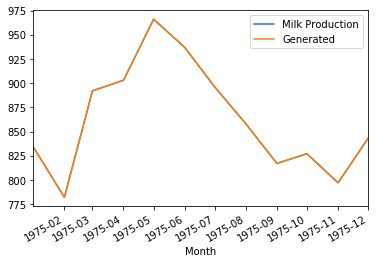

In [31]:
x_test.plot()

# Great Job!

Play around with the parameters and RNN layers, does a faster learning rate with more steps improve the model? What about GRU or BasicRNN units? What if you train the original model to not just predict one timestep ahead into the future, but 3 instead? Lots of stuff to add on here!